In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
import torch 
from torch import nn
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

# CHEM 277B - HW 8: Residual Neural Network #

## 1. Residual Neural Networks Applied to Classification ##

We will again use the MNIST data set to train, validation, and test but this time
using a ResNN. As described in lecture, we are going to formulate a skip
connection in order to improve gradient flow.
Using the CNN developed in HW#8, adapt your architecture to the one
shown in the figure below (architecture with two layers each composed
of one convolution and one pooling layer.) Use ReLU as your activation
function. Use conv/pooling layers that with kernel, stride and padding
size that lead to output size of 12x5x5 before flattening. Flatten the
resulting feature maps and use two fully connected (FC) layers of output
size (300,10). Add an additive skip connection from flattened layer to the
second fully connected layer. Again, use the ADAM optimizer with
learning rate of 1e-3, batchsize of 128, and 30 epochs (you can also train for longer if time permits). Split
the MNIST training set into 2/3 for training and 1/3 for validation, you don’t need to do KFold this time.
Use batch normalization of data, choose some regularization techniques and converge your training to
where the loss function is minimal.

![Residual Neural Network](Residual_Neural_Network.png)

In [2]:
# import mnist
mnist = pd.read_pickle('../Datasets/mnist.pkl')

mnist[0][0].shape

(60000, 32, 32)

In [3]:
class ResNet(nn.Module):
    '''
    Residual Neural Network class
    batch_norm: bool
        whether or not to use batch normalization
    skip_connection: bool
        whether or not to use skip connection
    '''
    def __init__(self, batch_norm, skip_connection):
        super(ResNet, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=1), 
            # (b, 1, 32, 32) -> (b, 6, 30, 30) -> (b, 6, 15, 15)
            nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1)
            # (b, 6, 15, 15) -> (b, 12, 15, 15) -> (b, 12, 5, 5)
        ])
        self.pooling = nn.ModuleList([
            nn.MaxPool2d(kernel_size=2),
            nn.MaxPool2d(kernel_size=3)
        ])
        self.fc = nn.ModuleList([nn.Linear(300, 300), nn.Linear(300, 10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6), nn.BatchNorm2d(12)]
        self.batch_norm = batch_norm
        self.skip = skip_connection

    def forward(self, input):
        input = input.view(-1, 1, 32, 32)
        x = self.conv[0](input)
        if self.batch_norm:
            x = self.bn[0](x)
        x = self.pooling[0](self.activation(x))
        x = self.conv[1](x)
        if self.batch_norm:
            x = self.bn[1](x)
        x = self.pooling[1](self.activation(x))
        x = nn.Flatten()(x)
        if self.skip:
            residual = x
        else:
            residual = 0
        x = self.fc[0](x)
        x += residual
        x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

In [4]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks


class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                ### Backpropagation ###
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                pred = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 == 0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, 
                                                                epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, 
                "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        self.model.eval() 
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute predictions and loss ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis=-1)
            batch_acc = torch.sum(pred == batch_output) / len(batch_output)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

Below is a function called `train_model` that splits the MNIST training set into 2/3 for training and 1/3 for validation and then trains the Residual Neural Network using these sets. This function also takes in boolean parameters for batch normalization and skip connections so that they can be easily implemented or turned off to observe the difference these techniques make during training.

In [5]:
def train_model(train_data, train_labels, test_data, test_labels,
                bn=False, skip=True, lr=1e-3, epochs=30):

    X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=1/3)

    ResNN = ResNet(batch_norm=bn, skip_connection=skip)
    resnet_trainer = Trainer(ResNN, optimizer_type="adam", learning_rate=lr, 
                             epoch=epochs, batch_size=128)

    log = resnet_trainer.train(X_train, y_train, X_val, y_val, l2=True)

    # Print the best epoch
    print('Epoch with lowest validation loss: %d' % (np.argmin(log['val_losses']) + 1))
    print('Epoch with highest validation accuracy: %d' % (np.argmax(log['val_accuracies']) + 1))

    # Plot the training and validation loss
    plt.plot(log['losses'], label='Training Loss')
    plt.plot(log['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(log['accuracies'], label='Training Accuracy')
    plt.plot(log['val_accuracies'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Report the final training and validation loss and accuracy
    test_loss, test_acc = resnet_trainer.evaluate(test_data, test_labels, print_acc=False)
    print('Final Results:')
    print('\nTraining Loss: %.3f' % log['losses'][-1])
    print('Validation Loss: %.3f' % log['val_losses'][-1])
    print('Test Loss: %.3f' % test_loss)
    print('\nTraining Accuracy: %.3f' % log['accuracies'][-1])
    print('Validation Accuracy: %.3f' % log['val_accuracies'][-1])
    print('Test Accuracy: %.3f' % test_acc)

## (a) ##
**Run the model with and without batch normalization. Which gives you better test accuracy?**

With batch normalization:

  3%|█▍                                          | 1/30 [00:06<03:22,  6.99s/it]

Epoch 1/30 - Loss: 1.696 - Acc: 0.782
              Val_loss: 1.595 - Val_acc: 0.869


 37%|███████████████▊                           | 11/30 [01:08<01:56,  6.14s/it]

Epoch 11/30 - Loss: 1.474 - Acc: 0.991
              Val_loss: 1.476 - Val_acc: 0.986


 70%|██████████████████████████████             | 21/30 [02:13<00:57,  6.38s/it]

Epoch 21/30 - Loss: 1.471 - Acc: 0.994
              Val_loss: 1.474 - Val_acc: 0.987


func:'train'  took: 190.9828 sec
Epoch with lowest validation loss: 30
Epoch with highest validation accuracy: 30


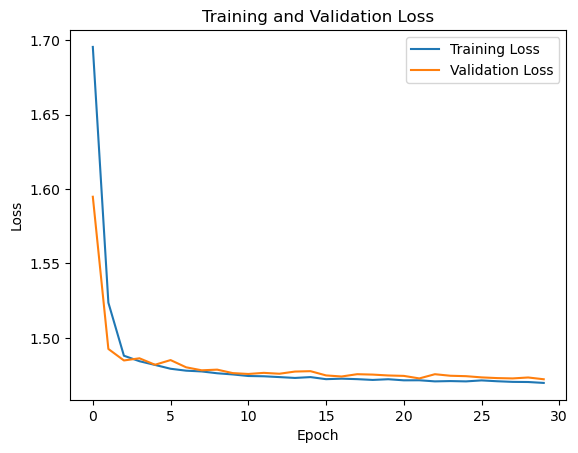

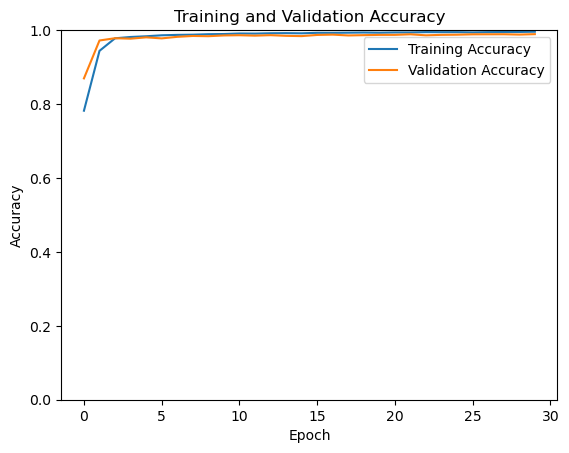

Final Results:

Training Loss: 1.470
Validation Loss: 1.472
Test Loss: 1.471

Training Accuracy: 0.996
Validation Accuracy: 0.989
Test Accuracy: 0.990


In [6]:
train_model(mnist[0][0], mnist[0][1], mnist[1][0], mnist[1][1], bn=True)

Without batch normalization:

  3%|█▍                                          | 1/30 [00:05<02:39,  5.51s/it]

Epoch 1/30 - Loss: 2.171 - Acc: 0.289
              Val_loss: 2.123 - Val_acc: 0.334


 37%|███████████████▊                           | 11/30 [01:03<01:54,  6.01s/it]

Epoch 11/30 - Loss: 1.685 - Acc: 0.778
              Val_loss: 1.687 - Val_acc: 0.774


 70%|██████████████████████████████             | 21/30 [02:00<00:49,  5.45s/it]

Epoch 21/30 - Loss: 1.592 - Acc: 0.873
              Val_loss: 1.584 - Val_acc: 0.877


func:'train'  took: 168.1986 sec
Epoch with lowest validation loss: 30
Epoch with highest validation accuracy: 30


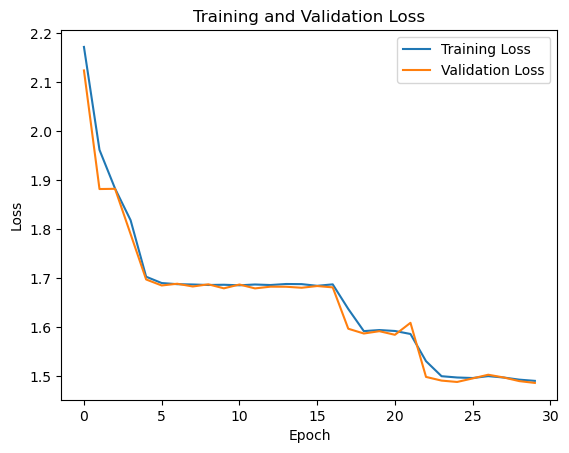

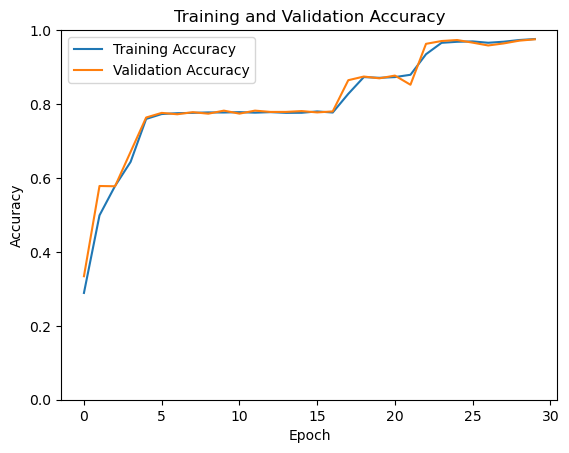

Final Results:

Training Loss: 1.490
Validation Loss: 1.486
Test Loss: 1.482

Training Accuracy: 0.976
Validation Accuracy: 0.975
Test Accuracy: 0.979


In [7]:
train_model(mnist[0][0], mnist[0][1], mnist[1][0], mnist[1][1], bn=False)

Without batch normalization, the testing accuracy was 0.979 compared to 0.990 using batch normalization, and batch normalization resulted in better accuracy for all training, validation, and testing data. 

## (b) ##

**Run the model with and without the skip connection at learning rate of 5e-3 for 10 epochs.
Do you see faster training and/or better test accuracy with the skip connection?**


With skip connection:

 10%|████▍                                       | 1/10 [00:06<01:00,  6.70s/it]

Epoch 1/10 - Loss: 1.876 - Acc: 0.583
              Val_loss: 1.591 - Val_acc: 0.872


func:'train'  took: 64.7975 sec
Epoch with lowest validation loss: 10
Epoch with highest validation accuracy: 10


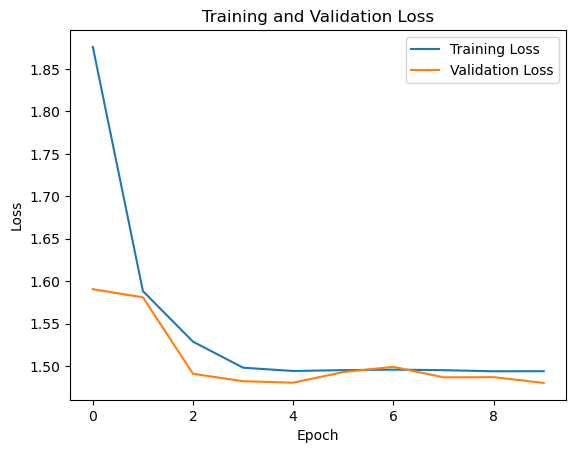

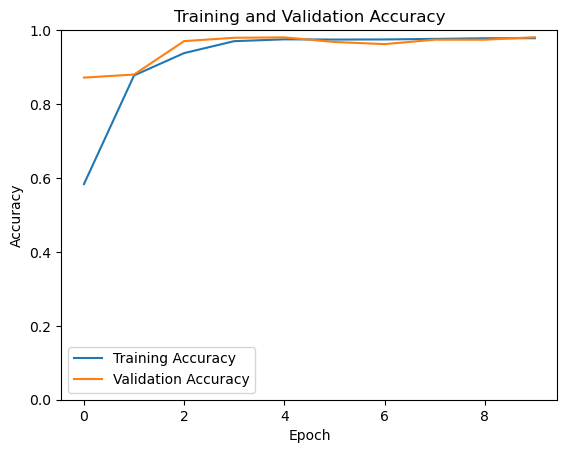

Final Results:

Training Loss: 1.494
Validation Loss: 1.480
Test Loss: 1.478

Training Accuracy: 0.978
Validation Accuracy: 0.981
Test Accuracy: 0.984


In [10]:
train_model(mnist[0][0], mnist[0][1], mnist[1][0], mnist[1][1], 
            bn=True, skip=True, lr=5e-3, epochs=10)

Without skip connections:

 10%|████▍                                       | 1/10 [00:06<00:54,  6.07s/it]

Epoch 1/10 - Loss: 1.747 - Acc: 0.716
              Val_loss: 1.596 - Val_acc: 0.865


func:'train'  took: 76.8331 sec
Epoch with lowest validation loss: 7
Epoch with highest validation accuracy: 7


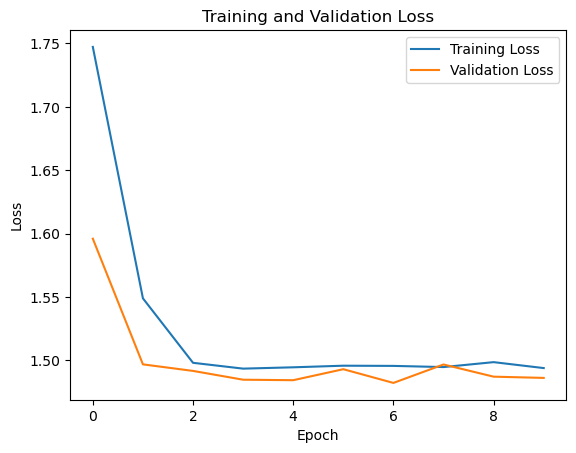

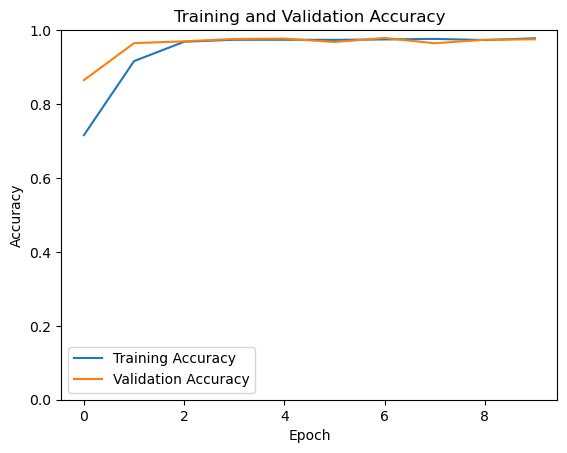

Final Results:

Training Loss: 1.494
Validation Loss: 1.486
Test Loss: 1.482

Training Accuracy: 0.978
Validation Accuracy: 0.975
Test Accuracy: 0.979


In [11]:
train_model(mnist[0][0], mnist[0][1], mnist[1][0], mnist[1][1], 
            bn=True, skip=False, lr=5e-3, epochs=10)

Test accuracy is slightly better when using the skip connection compared to not using it (0.984 vs 0.979). However, the runtime was quite significantly faster with a difference of approximately 12 seconds, from 76.83 seconds down to 64.90 seconds when using the skip connection. Therefore, skip connnections do seem to optimize the Residual neural network model!